# Trying vector codings 

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from Bio.Data import IUPACData
from collections import defaultdict
from itertools import product, combinations
from scipy.spatial.distance import hamming
import scipy.stats as ss
import cvxpy as cp
import sys
import scipy.linalg as sl

sys.path.append("../") 
import doe_utils

# TEST MAKE AMINO ACID WORLD SMALL 

AMINO_ACIDS = doe_utils.AMINO_ACIDS

In [2]:
length_of_protein = 100
num_mutated = 5
sold_mat_df, parent, mut_dict = doe_utils.create_synthetic_SOLD_matrix(num_mutated, length_of_protein, \
                                mut_probs = [[0.4, 0.4], [0.4, 0.4], [0.2, 0.3, 0.3], [0.2, 0.2, 0.4], [0.4, 0.4]], parent_prob=0.20) #6 postions mutated, pprtein length is 100 
sold_mat_df.head() 

Parent protein: HVHVPQSLWEFWRIWLVAYHMDQTRRQHNESGTTKSIFYNADIGNDNIEEITMRIIPDSQITTIPPEHFTLLVSPMGILSWMQCSPHKYHIIFTTQTEGR
Random mutaed positions [11 23 25 43 96]


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.4,0.0,0.0,0.0
C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
F,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


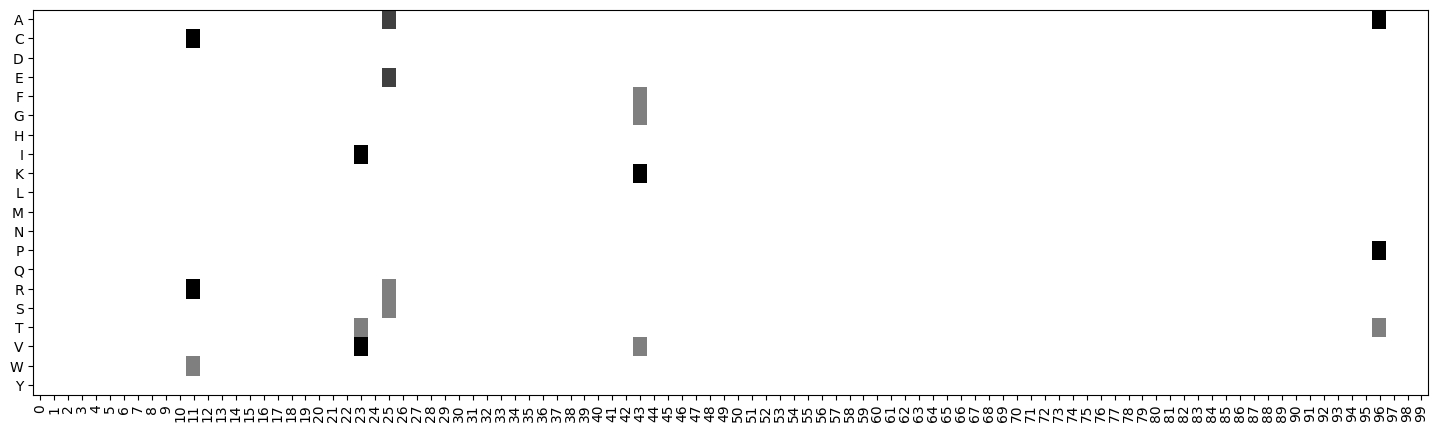

In [3]:
plt.figure(figsize = (18,5))
plt.imshow(sold_mat_df, aspect = 'auto', cmap = 'grey_r') 
_  = plt.xticks(range(length_of_protein), rotation = 90)
_  = plt.yticks(range(len(AMINO_ACIDS)), AMINO_ACIDS)


In [4]:
S = doe_utils.SOLD(sold_mat_df)
seqs, mutations = S.generate_sequences(1000)
seqs = np.unique(seqs)
probs = S.compute_prob_n_mutations(num_mutated+1)

In [5]:
S.mutation_probs_variable_region_indexed

defaultdict(None,
            {0: {'C': 0.4, 'R': 0.4, 'W': 0.2},
             1: {'I': 0.4, 'T': 0.2, 'V': 0.4},
             2: {'A': 0.3, 'E': 0.3, 'R': 0.2, 'S': 0.2},
             3: {'F': 0.2, 'G': 0.2, 'K': 0.4, 'V': 0.2},
             4: {'A': 0.4, 'P': 0.4, 'T': 0.2}})

# Now you have variable length mat to create encoder 

In [6]:

import cvxpy as cp 

from doe_utils import Sequence_encoder_simplex


class Fitting_model: 
    """
    l1 norm fitting model of data, with different penalty for indepednent and pairwise parameters 
    """
    def __init__(self, mutation_probs_variable_region_dict): 
        """
        I need to SOLD matrix dict to get to the right parameters to fit 
        
        Args: 
            pass the dict of mutation probs (this is generated by SOLD matrix class, attribute of dict is called mutation_probs_variable_region_indexed) 
            example:
            {0: {'D': 0.05, 'K': 0.85, 'M': 0.05, 'Y': 0.05},
             1: {'C': 0.05, 'G': 0.05, 'I': 0.05, 'P': 0.85},
             2: {'F': 0.05, 'N': 0.05, 'R': 0.85, 'Y': 0.05},
             3: {'G': 0.05, 'I': 0.05, 'L': 0.85, 'Q': 0.05},
             4: {'A': 0.05, 'E': 0.05, 'R': 0.05, 'W': 0.85},
             5: {'A': 0.05, 'D': 0.05, 'I': 0.85, 'K': 0.05}}
            where the keys are the index of the mutated regions and the values are dicts of probs of each amino acid
        
        """
        self.mutation_probs_variable_region_dict = mutation_probs_variable_region_dict
        self.mutated_region_length = len(mutation_probs_variable_region_dict) 
        self.encoder = Sequence_encoder_simplex(self.mutation_probs_variable_region_dict)


    def fit(self, seqs, activities, lambda_I = 0.00001, lambda_P = 0.0001): 
        """
        Fit seqs to their activities 
        The seqs are ONLY variable regions seqs concatenated! No point trying to fit regions that don't vary in the SOLD experiment! 
        Args: 
            seqs
            activities: vector of real values 
        """
        assert len(seqs) == len(activities), "Seqs (X) and activities (y) should be same length vectors"
        independent_codes, pairwise_codes = self.encoder.encode_seqs(seqs)

        flatten_independent = [] 
        for ind in independent_codes:
            flatten_independent.append([item for x in ind for item in x])
        flatten_independent = np.asarray(flatten_independent) 

        flatten_pairwise = [] 
        for ind in pairwise_codes:
            flatten_pairwise.append([item for x in ind for item in x])
        flatten_pairwise = np.asarray(flatten_pairwise) 
        # Now I need to select the features that are actually explored in the SOLD matrix---both for independent and pairwise 
        # first fit the independent parameters so that the pairwise paramaters are truly only pariwise, and cannot be explained away by independent by reparameterization 
        
        self.features = np.concatenate([flatten_independent, flatten_pairwise], axis = 1)
        
        self.independent_indices = np.arange(self.encoder.code_length_independent) # first few are independent features 
        self.pairwise_indices = np.arange(self.encoder.code_length_independent, self.encoder.number_of_features)  # the second set is pariwise features 

        # I need to perform a constrained optimization
        beta = cp.Variable(self.encoder.number_of_features)
        
        loss = cp.sum_squares(activities - self.features @ beta)    
        penalty = (lambda_I * cp.norm1(beta[self.independent_indices]) +
                   lambda_P * cp.norm1(beta[self.pairwise_indices]))
        objective = cp.Minimize(loss + penalty)
        # Define the problem and solve
        problem = cp.Problem(objective)
        problem.solve()        
        predicted_activities = np.dot(self.features, beta.value) 
        return beta.value, predicted_activities  
        
    


In [7]:
Q = doe_utils.Encoding_basics(S.mutation_probs_variable_region_indexed)

E = doe_utils.Sequence_encoder_simplex(S.mutation_probs_variable_region_indexed)
independent_codes, pairwise_codes = E.encode_seqs(seqs)

In [8]:
model = doe_utils.Create_in_silico_model(S.mutation_probs_variable_region_indexed)

(array([ 2.,  2., 17., 19., 57., 84., 82., 59., 19.,  6.]),
 array([-6.05615238, -5.03688805, -4.01762371, -2.99835938, -1.97909504,
        -0.95983071,  0.05943363,  1.07869796,  2.0979623 ,  3.11722663,
         4.13649097]),
 <BarContainer object of 10 artists>)

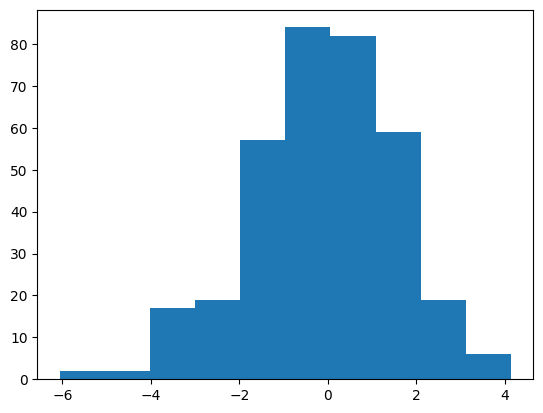

In [9]:
responses = model.model(independent_codes, pairwise_codes)
plt.hist(responses)

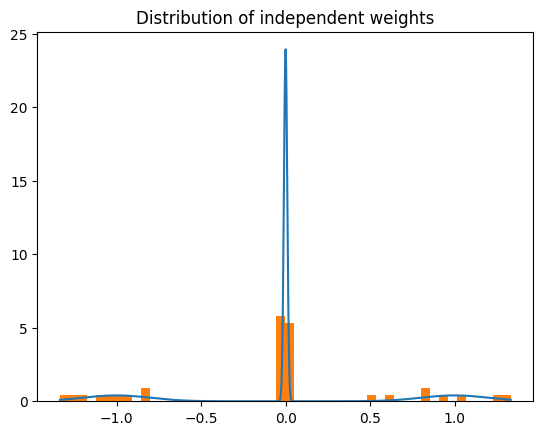

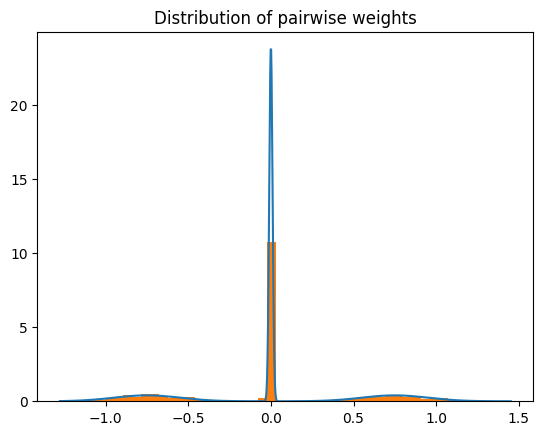

In [10]:
model.plot_weights()

In [11]:
fit_model = Fitting_model(S.mutation_probs_variable_region_indexed)
weights, fit_responses = fit_model.fit(seqs, responses)

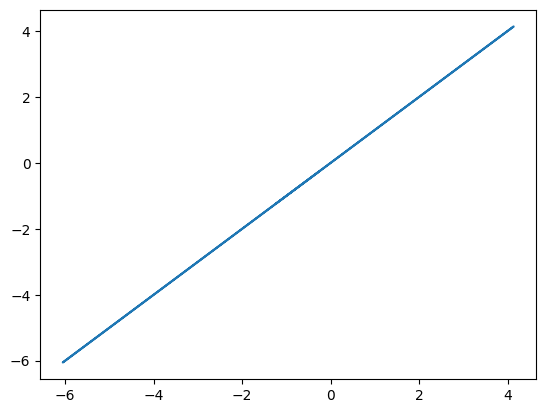

In [12]:
plt.plot(fit_responses, responses)

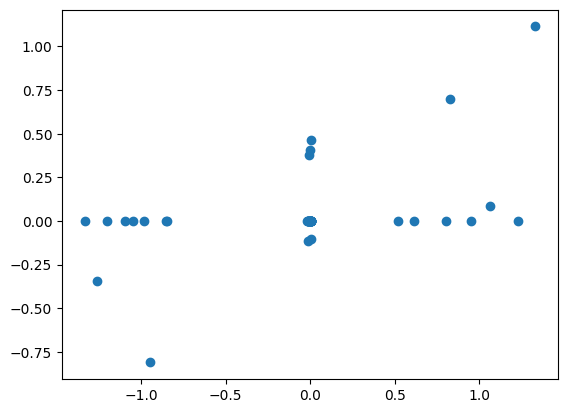

In [13]:
plt.scatter(model.independent_weights, weights[fit_model.independent_indices])

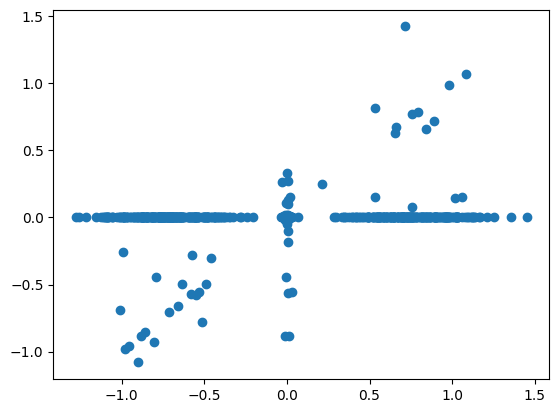

In [14]:
plt.scatter(model.pairwise_weights, weights[fit_model.pairwise_indices])

In [17]:
a, b = np.linalg.eig(fit_model.features.dot(fit_model.features.T))

/Users/swagatammukhopadhyay/anaconda3/envs/pytorch_env/lib/python3.13/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/swagatammukhopadhyay/anaconda3/envs/pytorch_env/lib/python3.13/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


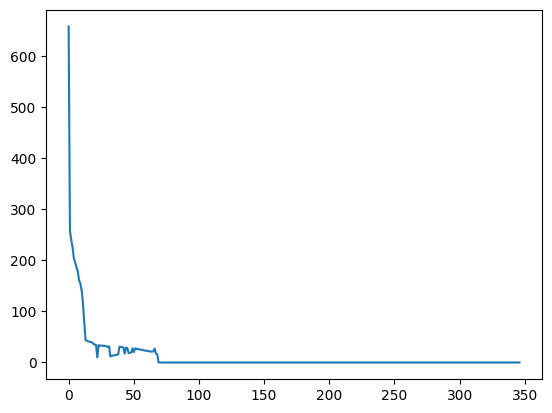

In [18]:
plt.plot(a)

In [19]:
len(pairwise_codes)

347

In [20]:
Q.feature_names_independent

['0-C',
 '0-R',
 '0-W',
 '1-I',
 '1-T',
 '1-V',
 '2-A',
 '2-E',
 '2-R',
 '2-S',
 '3-F',
 '3-G',
 '3-K',
 '3-V',
 '4-A',
 '4-P',
 '4-T']

In [22]:
len(Q.feature_names_pairwise)

115

In [23]:
len(Q.feature_names_independent)

17

In [24]:
115*17

1955